In [ ]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# LCLS Classic model 

In [2]:
from lcls_live.bmad import LCLSTaoModel
from lcls_live.epics import epics_proxy

import numpy as np
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Make sure this exists
assert 'LCLS_CLASSIC_LATTICE' in os.environ

In [4]:
# Optional.
# For archiver, if off-site

# Open an SSH tunnel in a terminal like:
# ssh -D 8080 cmayes@rhel6-64.slac.stanford.edu 
# And then set:
os.environ['http_proxy']='socks5h://localhost:8080'
os.environ['HTTPS_PROXY']='socks5h://localhost:8080'
os.environ['ALL_PROXY']='socks5h://localhost:8080'

# Get snapshot

In [5]:
# Cached EPICS pv data
epics = epics_proxy('data/epics_snapshot_2018-03-06T11:22:45.000000-08:00.json', verbose=True)

Loaded data/epics_snapshot_2018-03-06T11:22:45.000000-08:00.json with 1722 PVs


In [6]:
M = LCLSTaoModel('lcls_classic', epics = epics,verbose=True, ploton=True)
print(M)

Initialized Tao with /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/tao.init
Loading all settings
Reading: settings/klystron_settings.bmad
Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/settings/klystron_settings.bmad
Reading: settings/linac_settings.bmad
Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/settings/linac_settings.bmad
Reading: settings/collimator_settings.bmad
Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/settings/collimator_settings.bmad
Calling: settings/LEM_settings.tao
Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/settings/LEM_settings.tao
offsetting bunch compressors
call /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/scripts/BC_offsets.tao
LEMing
call /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/scripts/LEM.tao
Configured.
_______________________________________________
___________________________________

In [7]:
%%tao
place floor beta_compare
set lattice base = model

-------------------------
Tao> place floor beta_compare
-------------------------
Tao> set lattice base = model
-------------------------
Tao> 


In [8]:
# Restore from some other time
M.archiver_restore('2018-11-06T11:22:45.000000-08:00')

Requesting: http://lcls-archapp.slac.stanford.edu/retrieval/data/getDataAtTime?at=2018-11-06T11:22:45.000000-08:00&includeProxies=true
Loading all settings
Reading: settings/klystron_settings.bmad
Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/settings/klystron_settings.bmad
Reading: settings/linac_settings.bmad
Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/settings/linac_settings.bmad
Reading: settings/collimator_settings.bmad
Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/settings/collimator_settings.bmad
Calling: settings/LEM_settings.tao
Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/settings/LEM_settings.tao
offsetting bunch compressors
call /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/scripts/BC_offsets.tao
LEMing
call /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpovd48b7f/tao/scripts/LEM.tao


## Track particles

In [9]:
%%tao
set beam_init beam_track_end = UEEND
set csr_param n_bin = 40
snparticle 10000
beamon
beamoff

-------------------------
Tao> set beam_init beam_track_end = UEEND
-------------------------
Tao> set csr_param n_bin = 40
-------------------------
Tao> snparticle 10000
-------------------------
Tao> beamon
Beam at Element: 1162. Time: 1 min
-------------------------
Tao> beamoff
-------------------------
Tao> 


In [10]:
h5file1 = os.path.join(os.getcwd(), 'test1.h5')
M.cmd('write beam -at UEBEG '+h5file1)

h5file2 = os.path.join(os.getcwd(), 'test2.h5')
M.cmd('write beam -at UEEND '+h5file2)

['[INFO] tao_write_cmd:',
 '    Written: /Users/chrisonian/Code/GitHub/lcls-live/examples/test2.h5']

# Functional usage

In [11]:
from lcls_live.bmad.evaluate import run_LCLSTao, evaluate_LCLSTao

In [12]:
settings00 = {
    'ele:O_BC1:angle_deg':-5.12345,
    'ele:O_BC2:angle_deg':-2.0,
    'ele:O_L1:phase_deg':-25.1,
    'ele:O_L2:phase_deg':-41.4,
    'ele:O_L3:phase_deg':0.0,
    'ele:O_L1_fudge:f': 1.0,
    'ele:O_L2_fudge:f': 1.0,
    'ele:O_L3_fudge:f': 1.0,
    'csr_param:n_bin':40,
    'csr_param ds_track_step':0.01,
    'beam_init:n_particle': 100,
    'beam_init:beam_saved_at':'CE11',
    'bmad_com:coherent_synch_rad_on':False
}

M = run_LCLSTao(settings=settings00)

In [13]:
# This will run the model, and return a dict with values from the following expressions
expressions = [
    'lat::orbit.x[end]',
    'beam::n_particle_loss[end]'    
]
evaluate_LCLSTao(settings=settings00, expressions=expressions)

{'lat::orbit.x[end]': 1.4073164558374e-16, 'beam::n_particle_loss[end]': 0.0}

# Plot

In [14]:
from pmd_beamphysics import ParticleGroup, particle_paths
from pmd_beamphysics.plot import marginal_plot

from h5py import File

In [15]:
#h1.close()
#h2.close()
h1 = File(h5file1, 'r')
h2 = File(h5file2, 'r')
bunch1 = h1['data/00001/particles']
bunch2 = h2['data/00001/particles']

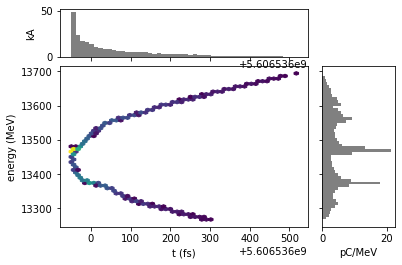

In [16]:
P1 = ParticleGroup(bunch1)
marginal_plot(P1, 't', 'energy')

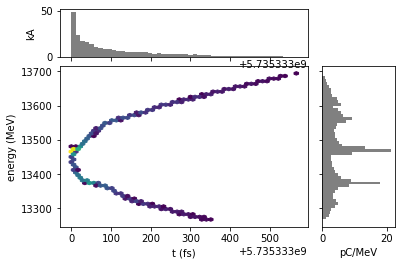

In [17]:
P2 = ParticleGroup(bunch2)
marginal_plot(P2, 't', 'energy')

In [18]:
# Cleanup
os.remove(h5file1), os.remove(h5file2)

(None, None)